In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
Citations = '''
  select *
  from    [dbo].[spd_PDCitations$]  
  '''
Citations = pd.read_sql(Citations, connection)
connection.close()

#filter for only citations of type 'DUI'
DUI_Citations = Citations.loc[Citations['Charge Description'].str.contains('DUI')]

#filter for only citations of the type 'DUI-BAC'
DUI_Citations_BAC = Citations.loc[Citations['Charge Description'].str.contains('DUI-BAC')]

#how many different types of citations are there?
DUI_Citations_types = DUI_Citations['Charge Description'].groupby(DUI_Citations['Charge Description'])
DUI_Citations_types.count() 

Charge Description
DUI-BAC of .08 or More                152
DUI-Drugs or Metabolite (13-3401)      29
DUI-Impaired to Slightest Degree     1648
Extreme DUI-BAC .15 or More            37
Extreme DUI-BAC .20 or More            12
Name: Charge Description, dtype: int64

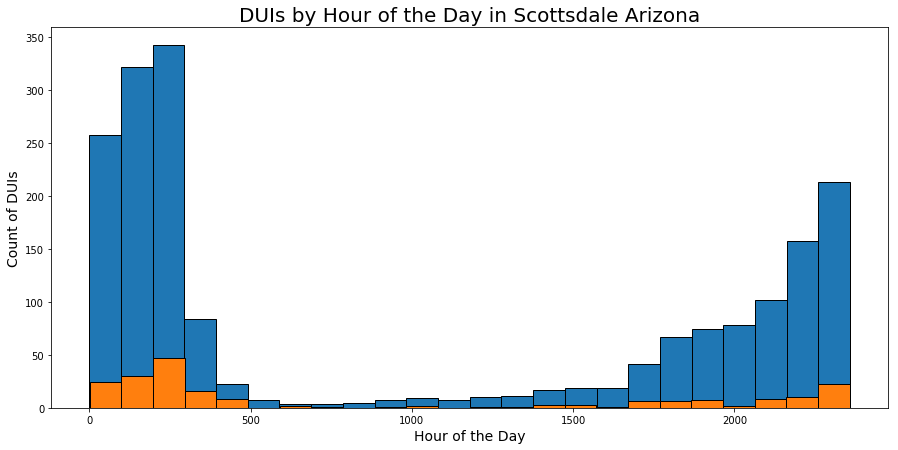

In [51]:
plt.rcParams["figure.figsize"] = [15, 7]    #sets the ploted size of the histogram
plt.title("DUIs by Hour of the Day in Scottsdale Arizona",fontsize=20)
plt.xlabel("Hour of the Day",fontsize=14)
plt.ylabel("Count of DUIs",fontsize=14)

with plt.style.context('default'):
    plt.hist(DUI_Citations['Citation Time'],bins=24,histtype='bar',edgecolor='black')
    plt.hist(DUI_Citations_BAC['Citation Time'],bins=24,histtype='bar',edgecolor='black')
plt.show()

In [16]:
# opens SQL query directly in Python, rather than open from CSV
 
# import libraries
# pyodbc for ODBC connection
import pyodbc
# pandas for 'excel' like sheets
import pandas as pd
# datetime for date computer date

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to find the percent of DUIs that take place at each intersection
DUILocations = '''
  select 
	 A.[Street]
	 ,A._Count_
	 ,convert(varchar,
			round(
				 convert(float, A._Count_)/convert(float, B._Total_)*100
				 ,2
			 )
	 ) + '%'as _Percent_
  from    (
		  select 
	      [Street]
		  ,count([Charge Description]) as _Count_
		  from [dbo].[spd_PDCitations$]
		  where [Charge Description] like '%DUI%'
		  group by [Street]
		  
  ) as A

  cross join  (
				select 
			    sum(_Count_) as _Total_
			    from (
				
				  select 
					[Street]
	               ,count([Charge Description]) as _Count_
                   from [dbo].[spd_PDCitations$]
                   where [Charge Description] like '%DUI%'
                   group by [Street]) as C  --interestingly an alias is needed here, even though I'm not calling the alias anywhere else in the querry
 ) as B 
			   
  group by A.[Street], A._Count_, (convert(float, A._Count_)/convert(float, B._Total_)*100)
  
  '''

# save the sql query to a pandas dataframe, or excel like sheet
DUILocations = pd.read_sql(DUILocations, connection)
connection.close()

                               Street  _Count_ _Percent_
128                E Indian School Rd      202     10.76
434                   N Scottsdale Rd      138      7.35
54                     E Camelback Rd       91      4.85
391  N Hayden Rd / E Indian School Rd       59      3.14
389                       N Hayden Rd       56      2.98
200                         E Shea Bl       54      2.88
159                     E McDowell Rd       43      2.29
62   E Camelback Rd / N Scottsdale Rd       28      1.49
415                       N Miller Rd       28      1.49
131  E Indian School Rd / N Miller Rd       25      1.33


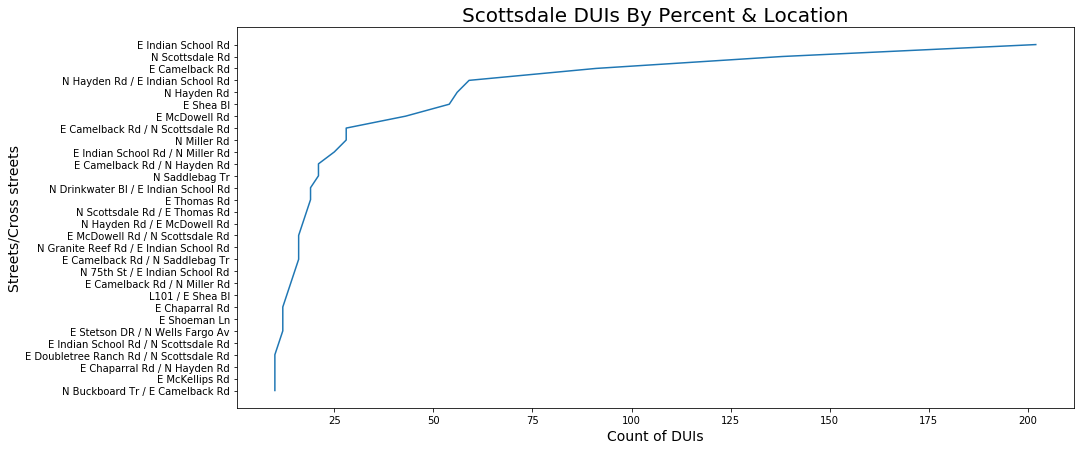

In [3]:
#Plot streets and count of DUIs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#remove percent character on the end of '_Percent_' field
DUILocations['_Percent_']= DUILocations['_Percent_'].str.replace('%','')

print(DUILocations.sort_values(['_Count_'], ascending=[0]).head(10))

plt.rcParams["figure.figsize"] = [15, 7]    #sets the ploted size
plt.title("Scottsdale DUIs By Percent & Location",fontsize=20)
plt.xlabel("Count of DUIs",fontsize=14)
plt.ylabel("Streets/Cross streets",fontsize=14)


top30 = DUILocations.sort_values(['_Count_'], ascending=[0]).head(30)
y = top30.sort_values(['_Count_'], ascending=[1]).loc[:,'_Count_'] 
x = top30.sort_values(['_Count_'], ascending=[1]).loc[:,'Street']
plt.plot(y,x)